## Setup

In [28]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics
import csv
import time
import itertools
from dateutil.relativedelta import relativedelta

from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal


import pmdarima as pya
import prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
sys.path.insert(0, '../code')
sys.path.insert(0, '../auth')
sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing plotly failed. Interactive plots will not work.


# EDA

In [6]:
ts = TimeSeries(key=av_key, output_format='csv')
# AV_COLUMNS = ['time', '1. open', '2. high', '3. low', '4. close', '5. volume']
AV_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume']

## Load Data

In [7]:
# df_full = get_all_data_slices('SPY', ts, verbose=1)
# df_full.to_csv('../data/SPY_2019_2021.csv')

Requesting all data slices for SPY...

0 0
Requesting slice: year1month1
First record:
                       open    high     low   close volume
time                                                      
2021-04-26 20:00:00  417.66  418.04  417.58  417.95  53372
Last record:
                       open    high     low   close volume
time                                                      
2021-03-29 05:00:00  394.03  394.03  393.19  393.68  87585
Processed and appended year1month1 to DataFrame.

0 1
Requesting slice: year1month2
First record:
                      open    high     low   close volume
time                                                     
2021-03-26 20:00:00  395.5  395.72  395.41  395.63  64946
Last record:
                              open           high            low  \
time                                                               
2021-02-26 05:00:00  382.843983138  382.843983138  381.687776367   

                            close volume  
time         

First record:
                              open           high            low  \
time                                                               
2020-05-29 20:00:00  301.062728359  301.239870393  301.023363463   

                             close  volume  
time                                        
2020-05-29 20:00:00  301.239870393  122070  
Last record:
                              open           high            low  \
time                                                               
2020-05-04 05:00:00  276.105383984  276.656492535  275.268879934   

                             close  volume  
time                                        
2020-05-04 05:00:00  275.357450951  114843  
Processed and appended year1month12 to DataFrame.

1 0
Requesting slice: year2month1
First record:
                              open           high            low  \
time                                                               
2020-05-01 20:00:00  278.359024308  278.447595325  278.280

Re-requesting slice: year2month10
First record:
                              open           high            low  \
time                                                               
2019-08-05 20:00:00  269.826082708  270.513969669  268.731276699   

                             close  volume  
time                                        
2019-08-05 20:00:00  269.283523978  515412  
Last record:
                             open          high            low          close  \
time                                                                            
2019-07-08 05:00:00  288.34089937  288.49591615  288.244013883  288.244013883   

                    volume  
time                        
2019-07-08 05:00:00   8514  
Processed and appended year2month10 to DataFrame.

1 10
Requesting slice: year2month11
First record:
                              open           high            low  \
time                                                               
2019-07-05 20:00:00  288.815638

In [8]:
# Get NYSE calendar
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early

,market_open,market_close
2012-07-02,2012-07-02 13:30:00+00:00,2012-07-02 20:00:00+00:00
2012-07-03,2012-07-03 13:30:00+00:00,2012-07-03 17:00:00+00:00
2012-07-05,2012-07-05 13:30:00+00:00,2012-07-05 20:00:00+00:00
2012-07-06,2012-07-06 13:30:00+00:00,2012-07-06 20:00:00+00:00
2012-07-09,2012-07-09 13:30:00+00:00,2012-07-09 20:00:00+00:00
2012-07-10,2012-07-10 13:30:00+00:00,2012-07-10 20:00:00+00:00


In [86]:
ticker = 'SPY'
date= 'year1month10'
apiKey = av_key

df_new = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+ticker+'&interval=60min&slice='+date+'&apikey='+apiKey+'&datatype=csv&outputsize=full') 

In [87]:
df_new.set_index('time', inplace=True)
df_new.index = pd.to_datetime(df_new.index)
df_new[(df_new.index>'2020-07-03') & (df_new.index<'2020-07-04')]

,open,high,low,close,volume
time,,,,,


In [16]:
df_full = pd.read_csv('../data/SPY_2019_2021.csv', index_col='time')
df_full.index = pd.to_datetime(df_full.index)

## Data Exploration

In [17]:
df_full.isna().sum()

open      311
high      311
low       311
close     311
volume    311
dtype: int64

## Set Proper Business Hour Frequency

In [18]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')

In [19]:
cbh

<CustomBusinessHour: CBH=05:00-21:00>

In [20]:
# try:
#     assert(type(df_new)=='pandas.core.frame.DataFrame')
# except AssertionError:
#     print('Nothing to append.')
# else:
#     df_full = df_full.append(df_new)
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
# finally:
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
#     df_full

Nothing to append


In [70]:
df = df_full.close
df[-16:]

time
2021-04-23 05:00:00    413.4500
2021-04-23 06:00:00    413.2200
2021-04-23 07:00:00    413.3000
2021-04-23 08:00:00    413.0800
2021-04-23 09:00:00    412.7200
2021-04-23 10:00:00    414.1800
2021-04-23 11:00:00    415.9601
2021-04-23 12:00:00    416.2505
2021-04-23 13:00:00    417.1020
2021-04-23 14:00:00    417.0200
2021-04-23 15:00:00    417.3750
2021-04-23 16:00:00    416.7200
2021-04-23 17:00:00    416.2500
2021-04-23 18:00:00    416.3600
2021-04-23 19:00:00    416.3300
2021-04-23 20:00:00    416.2500
Freq: CBH, Name: close, dtype: float64

In [ ]:
df_full.index

In [22]:
df.index

DatetimeIndex(['2019-05-07 05:00:00', '2019-05-07 06:00:00',
               '2019-05-07 07:00:00', '2019-05-07 08:00:00',
               '2019-05-07 09:00:00', '2019-05-07 10:00:00',
               '2019-05-07 11:00:00', '2019-05-07 12:00:00',
               '2019-05-07 13:00:00', '2019-05-07 14:00:00',
               ...
               '2021-04-23 11:00:00', '2021-04-23 12:00:00',
               '2021-04-23 13:00:00', '2021-04-23 14:00:00',
               '2021-04-23 15:00:00', '2021-04-23 16:00:00',
               '2021-04-23 17:00:00', '2021-04-23 18:00:00',
               '2021-04-23 19:00:00', '2021-04-23 20:00:00'],
              dtype='datetime64[ns]', name='time', length=8224, freq='CBH')

## Test out read and write CSV at same time

In [ ]:
with open('../data/GME_intra_Mar_29_Apr_12.csv', newline='') as csvfile:
#     fieldnames = ['first_name', 'last_name']
    reader = csv.reader(csvfile)
    fieldnames = next(reader)
    print(fieldnames)
    
    with open('../data/output.csv', mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)
        for row in reader:
            writer.writerow(row)
            

## More EDA

In [73]:
df_full[df_full.index>'2020-07-03']

,open,high,low,close,volume
time,,,,,
2020-07-03 05:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 06:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 07:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 08:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 09:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-04-23 16:00:00,417.371,418.25,416.64,416.72,20654032.0
2021-04-23 17:00:00,416.690,416.84,416.17,416.25,8698768.0
2021-04-23 18:00:00,416.270,416.74,416.14,416.36,185872.0


In [76]:
df_full[(df_full.index>'2020-07-03') & (df_full.index<'2020-07-04')]

,open,high,low,close,volume
time,,,,,
2020-07-03 05:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 06:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 07:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 08:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 09:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 10:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 11:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 12:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 13:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
start = pd.to_datetime('2019-06-07')

In [ ]:
cbh.next_bday(pd.to_datetime(start))

In [ ]:
start + pd.DateOffset(days = 2)

In [ ]:
start + pd.offsets.BDay()

In [ ]:
df_copy = df_full.copy()
df_copy.index = df_copy.index.date
df_copy.index.value_counts()

In [ ]:
# df_copy_2 = df_full2.copy()
# df_copy_2.index = df_copy_2.index.date
# df_copy_2.index.value_counts()

In [ ]:
df_full2[df_full2.index.date == pd.to_datetime('2020-07-06')]

In [ ]:
df_full[df_full.index.date == pd.to_datetime('2021-03-01')]

In [ ]:
null_data = df_full[df_full.isnull().any(axis=1)]
null_data

In [ ]:
null_data2 = df_full2[df_full2.isnull().any(axis=1)]
null_data2

In [ ]:
y=1
m=11
data_slice = f'year{y+1}month{m+1}'
print(data_slice)
total_data_reader, total_meta_data = ts.get_intraday_extended(symbol='SPY', interval='60min', slice=data_slice)
fieldnames = next(total_data_reader)
print(fieldnames)
df_test = pd.DataFrame(total_data_reader, columns=fieldnames)
df_test.set_index('time', inplace=True)
df_test

In [ ]:
with open('../data/output.csv', mode='w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=df_test_dict.keys())
#     writer = csv.DictWriter(sys.stderr, fieldnames=df_test_dict.keys())
#     writer = csv.writer(sys.stderr)
    writer = csv.writer(csvfile)
    writer.writerow(df_test.reset_index().columns)
#     writer.writeheader()
    writer.writerows(df_test.reset_index().values)

In [ ]:
df_test_close = df_test.close

# Data Prep

## Check Stationarity

In [ ]:
test_stationarity(df.dropna())

In [ ]:
test_stationarity(df.dropna(),1)

## Plot Seasonal Decomposition

In [ ]:
print(top)

In [ ]:
plot_seasonal_decomposition(df.dropna(), 'SPY', round(365/4))

# Modeling

## SARIMA

In [ ]:
round((80/100)*len(df))

In [ ]:
df_train, df_test = train_test_split_data(df, 80)

In [ ]:
param_list = []
param_seasonal_list = []
aic_list = []

In [1]:
param = (2,1,0)
param_seasonal = (2,1,0,2190)

In [23]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [24]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

## Auto ARIMA

In [26]:
# pya.auto_arima(df.dropna(), seasonal=True, m=2190).summary()

KeyboardInterrupt: 

## Facebook Prophet

In [41]:
df_pro = pd.DataFrame(df.reset_index())
df_pro.columns = ['ds','y']

In [42]:
df_pro

,ds,y
0,2019-05-07 05:00:00,281.033359
1,2019-05-07 06:00:00,280.956226
2,2019-05-07 07:00:00,280.483787
3,2019-05-07 08:00:00,280.136690
4,2019-05-07 09:00:00,280.368088
...,...,...
8219,2021-04-23 16:00:00,416.720000
8220,2021-04-23 17:00:00,416.250000
8221,2021-04-23 18:00:00,416.360000
8222,2021-04-23 19:00:00,416.330000


In [44]:
promod = prophet.Prophet()
promod.fit(df_pro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [68]:
future = promod.make_future_dataframe(periods=16, freq=cbh)
future.tail(32)

,ds
8208,2021-04-23 05:00:00
8209,2021-04-23 06:00:00
8210,2021-04-23 07:00:00
8211,2021-04-23 08:00:00
8212,2021-04-23 09:00:00
8213,2021-04-23 10:00:00
8214,2021-04-23 11:00:00
8215,2021-04-23 12:00:00
8216,2021-04-23 13:00:00
8217,2021-04-23 14:00:00


In [50]:
forecast = promod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8235,2021-04-26 16:00:00,408.524646,401.382532,415.210783
8236,2021-04-26 17:00:00,408.583149,402.017356,415.542293
8237,2021-04-26 18:00:00,408.653672,401.983236,415.097077
8238,2021-04-26 19:00:00,408.728915,402.133891,415.699690
8239,2021-04-26 20:00:00,408.791958,401.862773,415.215570


In [67]:
df_pro[-16:]

,ds,y
8208,2021-04-23 05:00:00,413.4500
8209,2021-04-23 06:00:00,413.2200
8210,2021-04-23 07:00:00,413.3000
8211,2021-04-23 08:00:00,413.0800
8212,2021-04-23 09:00:00,412.7200
8213,2021-04-23 10:00:00,414.1800
8214,2021-04-23 11:00:00,415.9601
8215,2021-04-23 12:00:00,416.2505
8216,2021-04-23 13:00:00,417.1020
8217,2021-04-23 14:00:00,417.0200


In [55]:
forecast[-32:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8208,2021-04-23 05:00:00,407.328997,401.324610,413.972331,407.328997,407.328997,0.261961,0.261961,0.261961,0.110186,0.110186,0.110186,0.151775,0.151775,0.151775,0.0,0.0,0.0,407.590957
8209,2021-04-23 06:00:00,407.342424,401.317213,414.490884,407.342424,407.342424,0.266631,0.266631,0.266631,0.117386,0.117386,0.117386,0.149245,0.149245,0.149245,0.0,0.0,0.0,407.609056
8210,2021-04-23 07:00:00,407.355852,401.319105,414.545588,407.355852,407.355852,0.235127,0.235127,0.235127,0.087083,0.087083,0.087083,0.148044,0.148044,0.148044,0.0,0.0,0.0,407.590979
8211,2021-04-23 08:00:00,407.369280,401.097964,414.236356,407.369280,407.369280,0.204455,0.204455,0.204455,0.056388,0.056388,0.056388,0.148067,0.148067,0.148067,0.0,0.0,0.0,407.573734
8212,2021-04-23 09:00:00,407.382707,400.718841,414.097608,407.382707,407.382707,0.200718,0.200718,0.200718,0.051531,0.051531,0.051531,0.149186,0.149186,0.149186,0.0,0.0,0.0,407.583425
8213,2021-04-23 10:00:00,407.396135,401.391869,414.632759,407.396135,407.396135,0.225001,0.225001,0.225001,0.073751,0.073751,0.073751,0.151250,0.151250,0.151250,0.0,0.0,0.0,407.621136
8214,2021-04-23 11:00:00,407.409563,401.722477,414.259689,407.409563,407.409563,0.258693,0.258693,0.258693,0.104611,0.104611,0.104611,0.154081,0.154081,0.154081,0.0,0.0,0.0,407.668255
8215,2021-04-23 12:00:00,407.422991,400.844123,414.077044,407.422991,407.422991,0.280145,0.280145,0.280145,0.122662,0.122662,0.122662,0.157484,0.157484,0.157484,0.0,0.0,0.0,407.703136
8216,2021-04-23 13:00:00,407.436418,401.056927,414.086373,407.436418,407.436418,0.278486,0.278486,0.278486,0.117246,0.117246,0.117246,0.161241,0.161241,0.161241,0.0,0.0,0.0,407.714904
8217,2021-04-23 14:00:00,407.449846,400.604064,414.392686,407.449846,407.449846,0.256558,0.256558,0.256558,0.091440,0.091440,0.091440,0.165118,0.165118,0.165118,0.0,0.0,0.0,407.706404


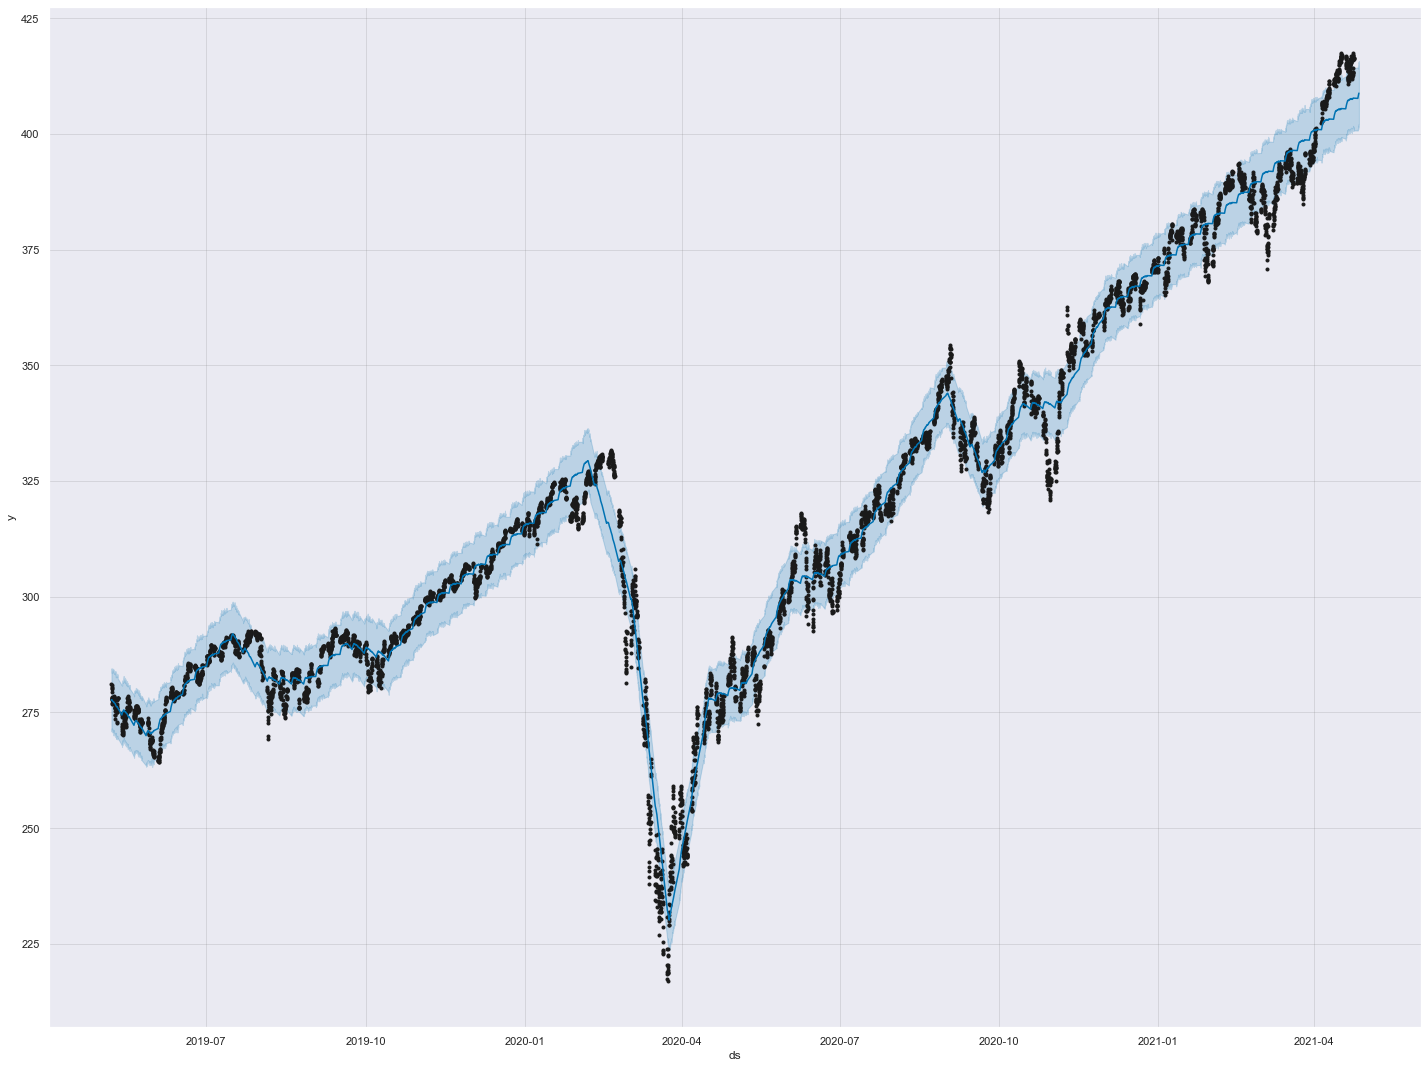

In [66]:
fig, ax = plt.subplots(figsize = (20,15))
promod.plot(forecast, ax=ax);
# start = pd.to_datetime('2021-04-23')
# end = pd.to_datetime('2021-04-26')
# ax.set_xlim(start,end)

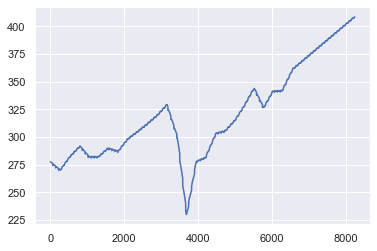

In [57]:
forecast.yhat.plot()

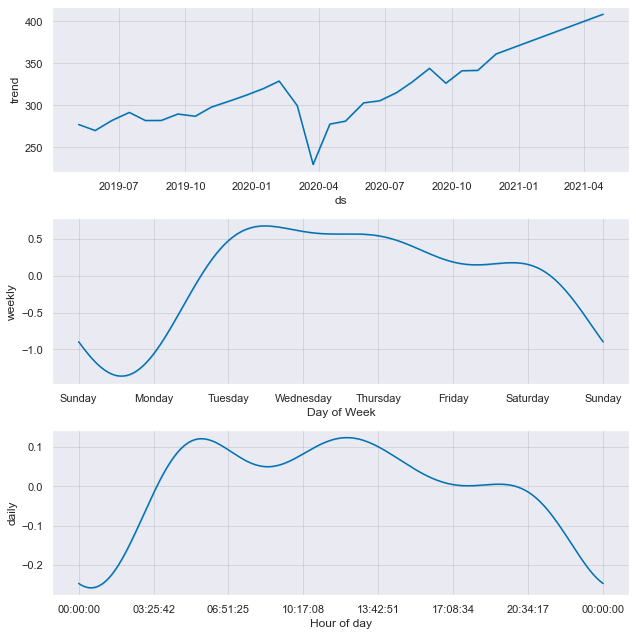

In [51]:
fig2 = promod.plot_components(forecast)
